# <font color=DarkBlue>Team: 5 STAR</font>

#### Team Members:

Akash Katakam, Harshitha Sanikommu, Maria Mathew, Nikhil Kashid, Soumya Murugendrappa

#### Under the Guidance Of:
Prof. Ramkumar Hariharan, Anitha Lakshmanan, Mihir Charudatta Salunke


# <font color=DarkBlue>Project: Predicting genre of a book by its cover</font>

## Problem Statement

Given the images of book covers including both fiction and non fiction images, we have to predict Genre of books.

There are around 12000 images in total which belong to 5 different categories as follows, our goal is to predict which genre does each image belongs to.
_"Comics&GraphicNovels", "Cookbooks", "KidsBooks", "MysteryThriller&Suspense", "ScienceFiction&Fantasy"_

## Introduction:

In this notebook, we will use 3 Transfer Learning models to train a classifier to identify 5 different categories in images. By visualizing the results to see the behavior of each model, we will identify the best model to further tune hyper parameters and test the model on both validation and testing datasets. 

There are around 2000 to 3000 images in each category with over 12000 images in total. The dataset is divided into 3 parts: Training (70%), validation (15%) and testing (15%)



Data was scraped using a python script and a csv file, both the files can be found in the submitted zip folder.


## Import necessary packages, and read in data

In [1]:
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations

from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
!which python

/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python


In [3]:
pwd

'/home/ubuntu'

In [4]:
# Location of data
datadir = '/home/ubuntu/FictionAndNonFictionImages/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'

save_file_name = 'model-transfer-1.pt'
checkpoint_path = 'model-transfer-1.pth'

# Change to fit hardware
batch_size = 32

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: False


### Data Exploration

In [5]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img = Image.open(traindir + d + '/' + i)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

category  n_train  n_valid  n_test
4                 KidsBooks     2100      450     450
1      Comics_GraphicNovels     1750      375     375
2    ScienceFiction_Fantasy     1632      350     350
5                 Cookbooks     1470      315     315
0  MysteryThriller_Suspense     1402      298     298

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

Text(0,0.5,'Count')

Text(0.5,1,'Training Images by Category')

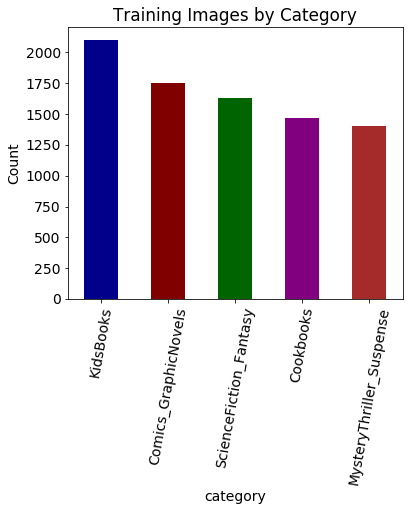

In [6]:

sns.set_style()
cat_df[0:5].set_index('category')['n_train'].plot.bar(
    color=['darkblue', 'maroon', 'darkgreen', 'purple', 'brown'], figsize=(6, 5))
plt.xticks(rotation=80)
plt.ylabel('Count')
plt.title('Training Images by Category')

In [7]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

height                                              \
                           count        mean        std    min    25%    50%   
category                                                                       
Comics_GraphicNovels      1750.0  493.505714  30.696931  140.0  500.0  500.0   
Cookbooks                 1470.0  485.842857  54.210257  140.0  500.0  500.0   
KidsBooks                 2100.0  478.821905  60.150666   60.0  500.0  500.0   
MysteryThriller_Suspense  1402.0  497.023538  23.386066  140.0  500.0  500.0   
ScienceFiction_Fantasy    1632.0  483.724877  55.247603  110.0  500.0  500.0   

                                         width                               \
                            75%    max   count        mean        std   min   
category                                                                      
Comics_GraphicNovels      500.0  500.0  1750.0  357.678286  48.135136  96.0   
Cookbooks                 500.0  500.0  1470.0  375.808844  62.861043  91.0   
KidsBooks                 500.0  500.0  2100.0  398.242857  78.699881  40.0   
MysteryThriller_Suspense  500.0  500.0  1402.0  328.145506  44.608395  88.0   
ScienceFiction_Fantasy    500.0  500.0  1632.0  359.684436  62.361107  90.0   

                                                      
                            25%    50%    75%    max  
category                                              
Comics_GraphicNovels      330.0  337.0  374.0  661.0  
Cookbooks                 333.0  385.0  405.0  500.0  
KidsBooks                 341.0  389.0  478.0  602.0  
MysteryThriller_Suspense  312.0  326.0  333.0  500.0  
ScienceFiction_Fantasy    330.0  354.0  385.0  623.0

<Figure size 720x432 with 0 Axes>

Text(0.5,0,'Pixels')

Text(0,0.5,'Density')

Text(0.5,1,'Average Size Distribution')

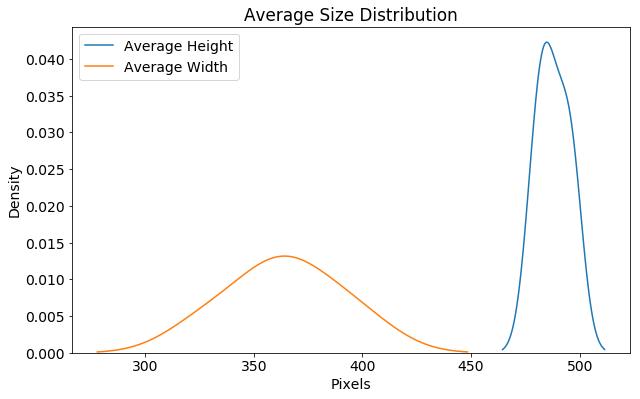

In [8]:
plt.figure(figsize=(10, 6))
sns.kdeplot(
    img_dsc['height']['mean'], label='Average Height')
sns.kdeplot(
    img_dsc['width']['mean'], label='Average Width')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Average Size Distribution')

(500, 500, 3)

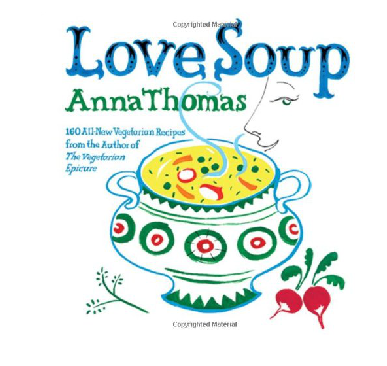

In [9]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example image
x = Image.open(traindir + 'Cookbooks/0393332578.jpg')
np.array(x).shape
imshow(x)

(500, 467, 3)

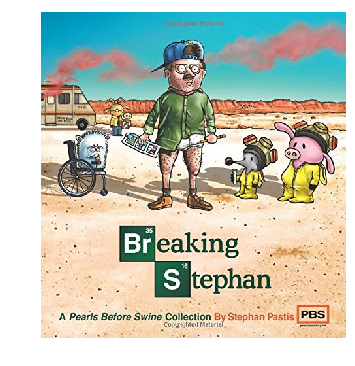

In [10]:
x = Image.open(traindir + 'Comics_GraphicNovels/1449458300.jpg')
np.array(x).shape
imshow(x)

## Image Preprocessing

To prepare the images for our network, we are resizing them to 224 x 224 and normalizing each color channel by subtracting a mean value and dividing by a standard deviation. We will also augment our training data in this stage. These operations are done using image transforms, which prepare our data for a neural network.

## Data Augmentation
Because there are a limited number of images in some categories, we can use image augmentation to artificially increase the number of images "seen" by the network. This means for training, we randomly resize and crop the images and also flip them horizontally. A different random transformation is applied to each epoch (while training), so the network effectively sees many different versions of the same image. All of the data is also converted to Torch Tensors before normalization. The validation and testing data is not augmented but is only resized and normalized. The normalization values are standardized for Imagenet.

In [11]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Examples of Augmentation
To show how augmentation works, we will write a function that will plot a tensor as an image.

In [12]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

We'll work with an example image and apply the train transformations

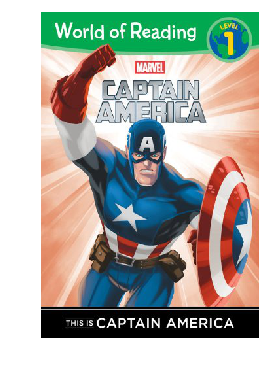

In [13]:
ex_img = Image.open(traindir + 'Comics_GraphicNovels/1484712676.jpg')
imshow(ex_img)

<Figure size 720x720 with 0 Axes>

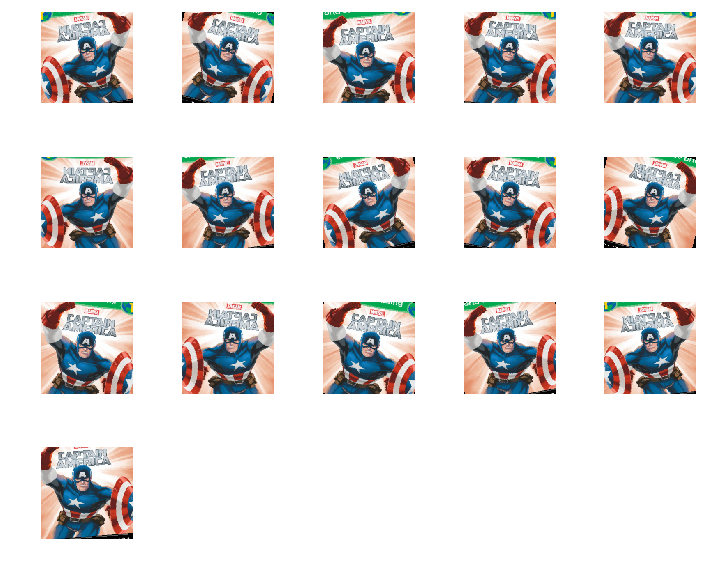

In [14]:
t = image_transforms['train']
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(5, 5, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

### Data Iterators
To avoid loading all of the data into memory at once, we use training DataLoaders. First, we create a dataset object from the image folders, and then we pass these to a DataLoader. At training time, the DataLoader will load the images from disk, apply the transformations, and yield a batch. To train and validation, we'll iterate through all the batches in the respective DataLoader.

One crucial aspect is to shuffle the data before passing it to the network. This means that the ordering of the image categories changes on each pass through the data (one pass through the data is one training epoch).

In [15]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [16]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Pre-Trained Models for Image Classification
PyTorch has many pretrained models we can use. All of these models have been trained on Imagenet which consists of millions of images across 1000 categories. With pretrained models, we will freeze the early layers, and replace the classification module with our own.

### Approach
The approach for using a pre-trained image recognition model is well-established:

1. Load in pre-trained weights from a network trained on a large dataset
2. Freeze all the weights in the lower (convolutional) layers
    - Layers to freeze can be adjusted depending on similarity of task to large training dataset
3. Replace the classifier (fully connected) part of the network with a custom classifier
    - Number of outputs must be set equal to the number of classes
4. Train only the custom classifier (fully connected) layers for the task
    - Optimizer model classifier for smaller dataset

In [17]:
n_classes = len(cat_df)

### Function to Load in Pretrained Model

In [18]:
def get_pretrained_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))
    elif model_name == 'googlenet':
        model = models.googlenet(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')


    return model

### Process to Use Pre-Trained Model

In [19]:
model_resnet = get_pretrained_model('resnet50')
summary(
        model_resnet, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

In [20]:
model_vgg = get_pretrained_model('vgg16')
summary(
        model_vgg, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

In [21]:
model_googlenet = get_pretrained_model('googlenet')
summary(
        model_googlenet, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
       BasicConv2d-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
       BasicConv2d-7           [32, 64, 56, 56]               0
            Conv2d-8          [32, 192, 56, 56]         110,592
       BatchNorm2d-9          [32, 192, 56, 56]             384
      BasicConv2d-10          [32, 192, 56, 56]               0
        MaxPool2d-11          [32, 192, 28, 28]               0
           Conv2d-12           [32, 64, 28, 28]          12,288
      BatchNorm2d-13           [32, 64, 28, 28]             128
      BasicConv2d-14           [32, 64,

In [22]:
model_resnet.class_to_idx = data['train'].class_to_idx
model_resnet.idx_to_class = {
    idx: class_
    for class_, idx in model_resnet.class_to_idx.items()
}

list(model_resnet.idx_to_class.items())[1:6]

[(1, 'Comics_GraphicNovels'),
 (2, 'Cookbooks'),
 (3, 'KidsBooks'),
 (4, 'MysteryThriller_Suspense'),
 (5, 'ScienceFiction_Fantasy')]

### Training Loss and Optimizer

In [23]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_resnet.parameters())

In [24]:
criterion2 = nn.NLLLoss()
optimizer2 = optim.Adam(model_vgg.parameters())

In [25]:
criterion3 = nn.NLLLoss()
optimizer3 = optim.Adam(model_googlenet.parameters())

In [26]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([6, 256])
torch.Size([6])


In [27]:
for p in optimizer2.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([6, 256])
torch.Size([6])


In [28]:
for p in optimizer3.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 1024])
torch.Size([256])
torch.Size([6, 256])
torch.Size([6])


## Training function

For training, we iterate through the train DataLoader, each time passing one batch through the model.
The below function trains the network while monitoring a number of different parameters. We train with early stopping on the validation set.

In [29]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=4,
          print_every=2):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

### Training three models

In [30]:
#Best epoch is determined by the one with minimum loss
model_resnet, history_resnet = train(
    model_resnet,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=4,
    n_epochs=4,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 349.76 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.1360 	Validation Loss: 1.0459
		Training Accuracy: 54.98%	 Validation Accuracy: 59.12%
Epoch: 1	100.00% complete. 354.57 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9967 	Validation Loss: 0.9923
		Training Accuracy: 60.99%	 Validation Accuracy: 61.35%
Epoch: 2	100.00% complete. 346.17 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.9572 	Validation Loss: 1.0128
		Training Accuracy: 62.95%	 Validation Accuracy: 59.90%
Epoch: 3	100.00% complete. 344.58 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.9415 	Validation Loss: 0.9897
		Training Accuracy: 63.44%	 Validation Accuracy: 61.19%

Best epoch: 3 with loss: 0.99 and acc: 61.19%
1764.99 total seconds elapsed. 588.33 seconds per epoch.


In [31]:
model_vgg, history_vgg = train(
    model_vgg,
    criterion2,
    optimizer2,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=4,
    n_epochs=4,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 527.00 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.9940 	Validation Loss: 1.0180
		Training Accuracy: 61.14%	 Validation Accuracy: 58.72%
Epoch: 3	100.00% complete. 539.10 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.9472 	Validation Loss: 0.9720
		Training Accuracy: 62.31%	 Validation Accuracy: 61.24%

Best epoch: 2 with loss: 0.97 and acc: 62.02%
2541.56 total seconds elapsed. 847.19 seconds per epoch.


In [32]:
model_googlenet, history_googlenet = train(
    model_googlenet,
    criterion3,
    optimizer3,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=4,
    n_epochs=4,
    print_every=2)

Starting Training from Scratch.

Epoch: 1	100.00% complete. 206.10 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.0605 	Validation Loss: 1.0563
		Training Accuracy: 58.76%	 Validation Accuracy: 59.56%
Epoch: 3	100.00% complete. 203.39 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.0067 	Validation Loss: 1.0248
		Training Accuracy: 61.26%	 Validation Accuracy: 60.51%

Best epoch: 2 with loss: 1.02 and acc: 60.79%
995.95 total seconds elapsed. 331.98 seconds per epoch.


### Hyper parameter tuning for resnet model:

Although all three models have shown similar performance, we are chosing Resnet model for further tuning

In [33]:
def train_2(model,
          criterion,
          optimizer,
          scheduler,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=4,
          n_epochs=4,
          print_every=2):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [34]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
model_resnet, history_resnet = train_2(
    model_resnet,
    nn.CrossEntropyLoss(),
    optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9),
    lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=10,
    n_epochs=10,
    print_every=2) 

Model has been trained for: 4 epochs.

Epoch: 1	100.00% complete. 352.16 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.8940 	Validation Loss: 0.9822
		Training Accuracy: 65.78%	 Validation Accuracy: 61.52%
Epoch: 3	100.00% complete. 354.83 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.8862 	Validation Loss: 0.9817
		Training Accuracy: 66.17%	 Validation Accuracy: 61.74%
Epoch: 5	100.00% complete. 357.58 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.8816 	Validation Loss: 0.9832
		Training Accuracy: 66.32%	 Validation Accuracy: 61.13%
Epoch: 7	100.00% complete. 363.02 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.8903 	Validation Loss: 0.9807
		Training Accuracy: 65.25%	 Validation Accuracy: 61.41%
Epoch: 9	100.00% complete. 354.56 seconds elapsed in epoch.
Epoch: 9 	Training Loss: 0.8922 	Validation Loss: 0.9826
		Training Accuracy: 66.03%	 Validation Accuracy: 60.91%

Best epoch: 8 with loss: 0.98 and acc: 61.97%
4483.47 total seconds elapsed. 498.16 second

As the performance of all three models are approximately same, we choose resnet which has nearly consistent loss and accuracy for each epoch

### Training Results
We can inspect the training progress by looking at the history

<Figure size 576x432 with 0 Axes>

Text(0.5,0,'Epoch')

Text(0,0.5,'Average Negative Log Likelihood')

Text(0.5,1,'Training and Validation Losses')

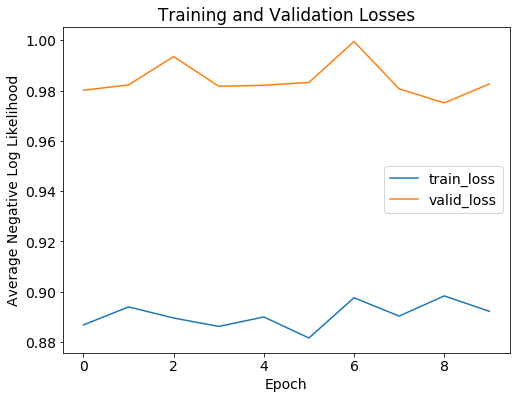

In [35]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history_resnet[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 576x432 with 0 Axes>

Text(0.5,0,'Epoch')

Text(0,0.5,'Average Accuracy')

Text(0.5,1,'Training and Validation Accuracy')

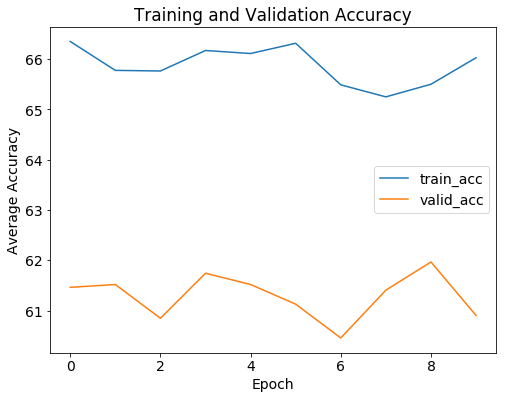

In [36]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history_resnet[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

## Inference
After the model has been trained to the point on no more improvement on the validation data, we need to test it on data it has never seen

This function processes an image path into a PyTorch tensor for predictions. It applies the same transformations as was done to the validation data: cropping (center) and normalizing with means and standard deviations.

In [37]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    # Resize
    img = image.resize((256, 256))

    # Center crop
    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [38]:
x = process_image(testdir + 'Comics_GraphicNovels/1608864774.jpg')
x.shape

torch.Size([3, 224, 224])

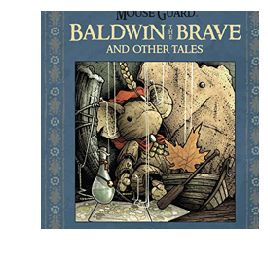

In [39]:
ax, image = imshow_tensor(x)

## Function to make predictions

The next function makes predictions on a single image. It will return the top probabilities and classes

In [40]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

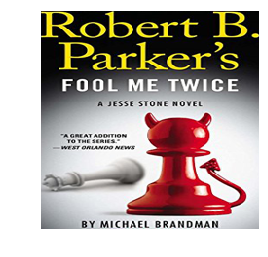

In [41]:
# function to pick a random test image
np.random.seed = 100


def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path


_ = imshow_tensor(process_image(random_test_image()))

In [42]:
img, top_p, top_classes, real_class = predict(random_test_image(), model_resnet)
img.shape

torch.Size([3, 224, 224])

In [43]:
top_p, top_classes, real_class

(array([ 0.64345527,  0.11978224,  0.08658051,  0.07508752,  0.07506349], dtype=float32),
 ['MysteryThriller_Suspense',
  'Cookbooks',
  'ScienceFiction_Fantasy',
  'KidsBooks',
  'Comics_GraphicNovels'],
 'MysteryThriller_Suspense')

In [44]:
img, top_p, top_classes, real_class = predict(random_test_image(), model_resnet)
top_p, top_classes, real_class

(array([  7.71960020e-01,   2.25789681e-01,   1.87773956e-03,
          2.92100536e-04,   8.03959410e-05], dtype=float32),
 ['Comics_GraphicNovels',
  'KidsBooks',
  'ScienceFiction_Fantasy',
  'MysteryThriller_Suspense',
  'Cookbooks'],
 'Comics_GraphicNovels')

### Function to Display Predictions
This function displays the picture along with the topk predictions from the model. The title over the image displays the true class.

In [45]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color=['blue', 'brown', 'darkblue', 'purple', 'green'], edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

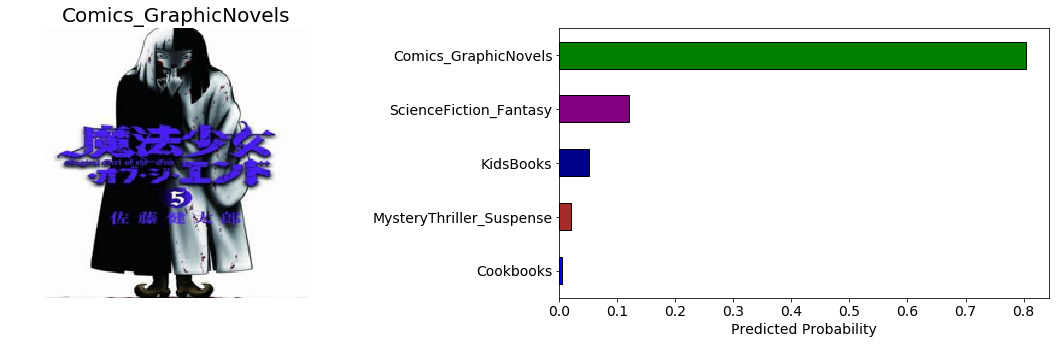

In [46]:
display_prediction(random_test_image(), model_resnet, topk=5)

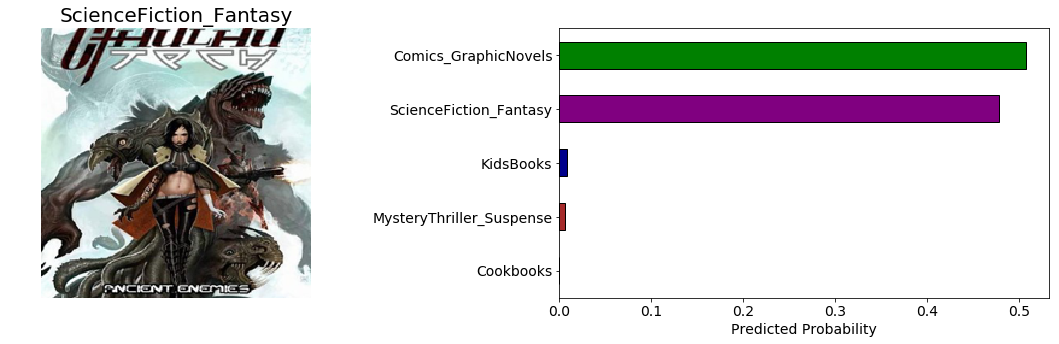

In [47]:
display_prediction(random_test_image(), model_resnet, topk=5)

### Testing Accuracy
Image identification models are usually assessed in terms of topk accuracy.
We'll assess out model by the top1 and top3 accuracy, that is, the percentage of predictions it gets exactly correct, and the percentage of predictions where the real class is in the top 3 actual classes

In [48]:
def accuracy(output, target, topk=(1,)):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [49]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_resnet(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model_resnet(features), targets, topk=(1, 5))

[71.875, 100.0]

### Function to Evaluate Model Over All Classes

This function iterates through the testing set in order to make predictions for each image. It calculates performance for each category.

In [50]:


def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [51]:
criterion = nn.NLLLoss()
# Evaluate the model on all the test data
results = evaluate(model_resnet, dataloaders['test'], criterion)
results.head()

class       top1   top5      loss
0      Comics_GraphicNovels  68.000000  100.0  0.789449
1                 Cookbooks  73.333333  100.0  0.762203
2                 KidsBooks  66.666667  100.0  0.862930
3  MysteryThriller_Suspense  73.489933  100.0  0.812384
4    ScienceFiction_Fantasy  44.000000  100.0  1.279263

Text(0.5,11.12,'images')

Text(3.87,0.5,'Accuracy (%)')

Text(0.5,1,'Top 1 Accuracy vs Number of Training Images')

(-5, 105)

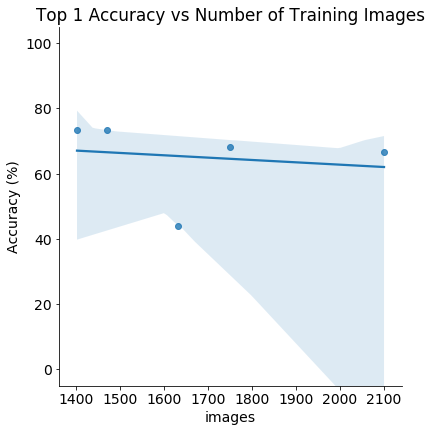

In [52]:
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [53]:
print('Category with minimum accuracy.')
results.loc[results['top1'].idxmin]

print('Category with minimum images.')
results.loc[results['n_train'].idxmin]

Category with minimum accuracy.


class      ScienceFiction_Fantasy
top1                           44
top5                          100
loss                      1.27926
n_train                      1632
n_valid                       350
n_test                        350
Name: 4, dtype: object

Category with minimum images.


class      MysteryThriller_Suspense
top1                        73.4899
top5                            100
loss                       0.812384
n_train                        1402
n_valid                         298
n_test                          298
Name: 3, dtype: object

Text(0.5,11.12,'images')

Text(-18.13,0.5,'Accuracy (%)')

Text(0.5,1,'Top 5 Accuracy vs Number of Training Images')

(-5, 105)

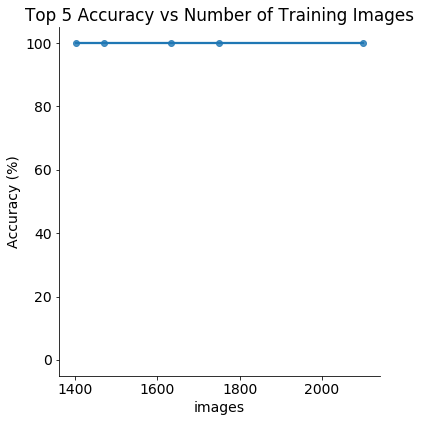

In [54]:
sns.lmplot(
    y='top5', x='n_train', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 5 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)

In [55]:
# Weighted column of test images
results['weighted'] = results['n_test'] / results['n_test'].sum()

# Create weighted accuracies
for i in (1, 5):
    results[f'weighted_top{i}'] = results['weighted'] * results[f'top{i}']

# Find final accuracy accounting for frequencies
top1_weighted = results['weighted_top1'].sum()
top5_weighted = results['weighted_top5'].sum()
loss_weighted = (results['weighted'] * results['loss']).sum()

print(f'Final test cross entropy per image = {loss_weighted:.4f}.')
print(f'Final test top 1 weighted accuracy = {top1_weighted:.2f}%')
print(f'Final test top 5 weighted accuracy = {top5_weighted:.2f}%')

Final test cross entropy per image = 0.9028.
Final test top 1 weighted accuracy = 64.82%
Final test top 5 weighted accuracy = 100.00%


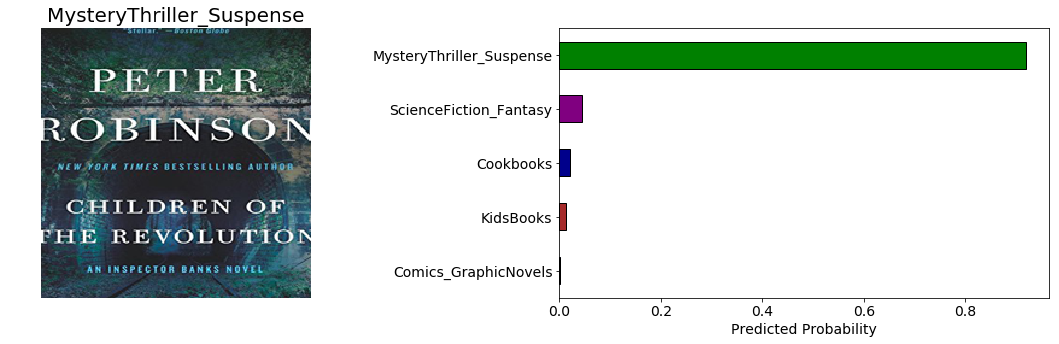

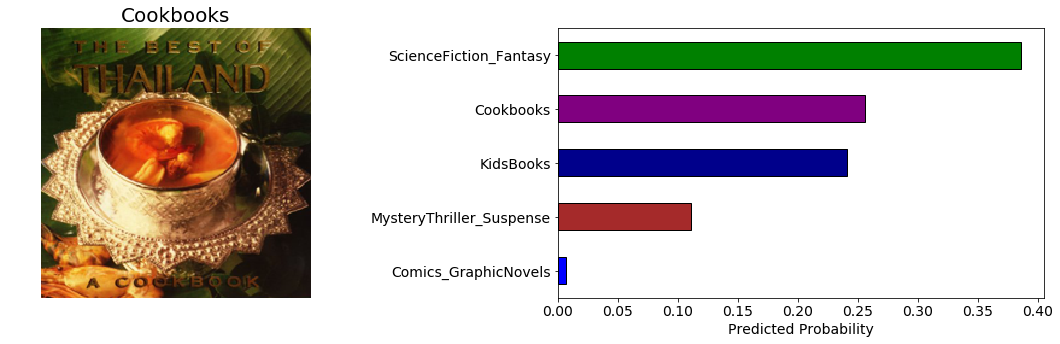

In [56]:
CompTech1 = testdir + 'MysteryThriller_Suspense/006224051X.jpg'
CompTech2 = testdir + 'Cookbooks/000255206X.jpg'

display_prediction(CompTech1, model_resnet, 5)
display_prediction(CompTech2, model_resnet, 5)

In [57]:
def display_category(model, category, n=3):
    """Display predictions for a category    
    """
    category_results = results.loc[results['class'] == category]
    print(category_results.iloc[:, :6], '/n')

    images = np.random.choice(
        os.listdir(testdir + category + '/'), size=3, replace=False)

    for img in images:
        display_prediction(testdir + category + '/' + img, model, 5)

       class       top1   top5      loss  n_train  n_valid
1  Cookbooks  73.333333  100.0  0.762203     1470      315 /n


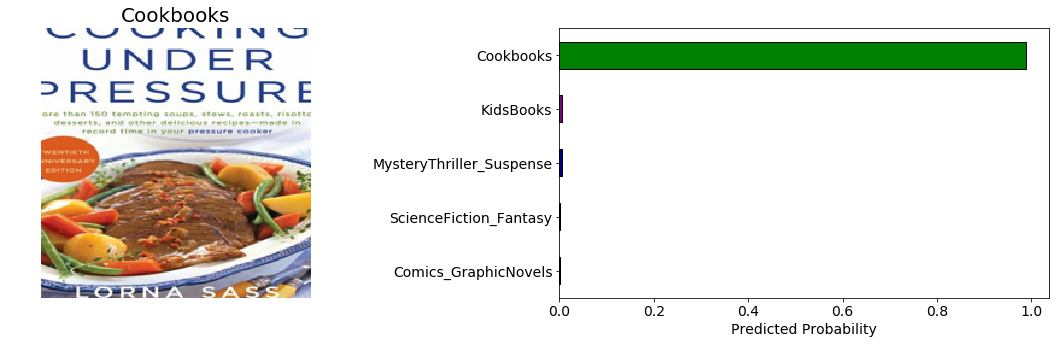

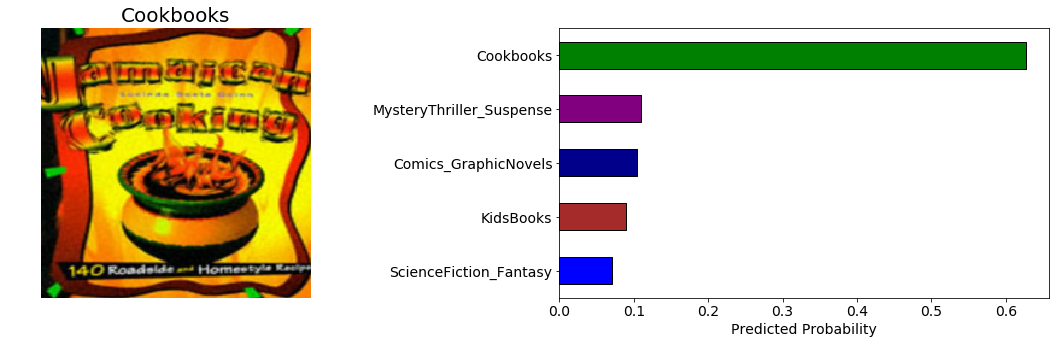

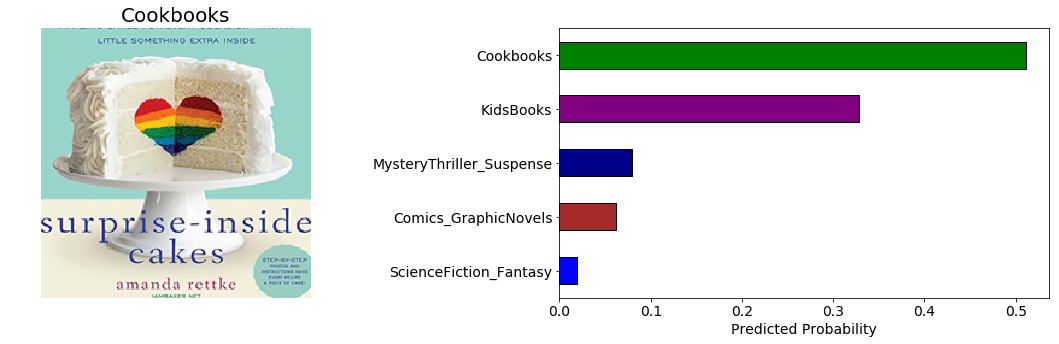

In [66]:
display_category(model_resnet, 'Cookbooks')

                  class  top1   top5      loss  n_train  n_valid
0  Comics_GraphicNovels  68.0  100.0  0.789449     1750      375 /n


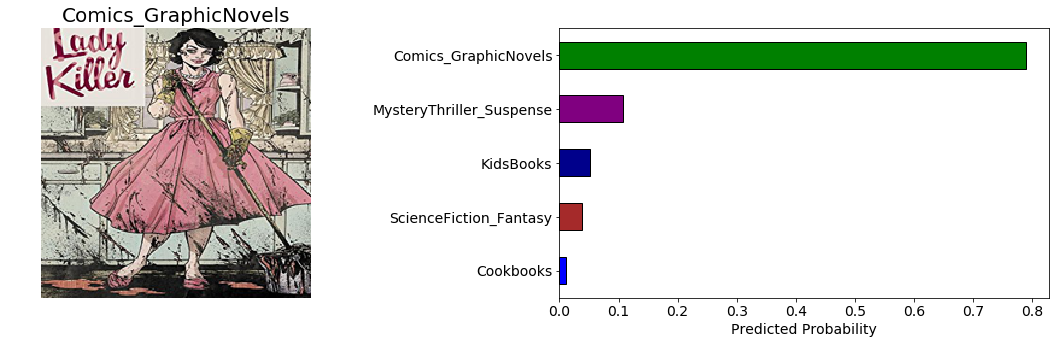

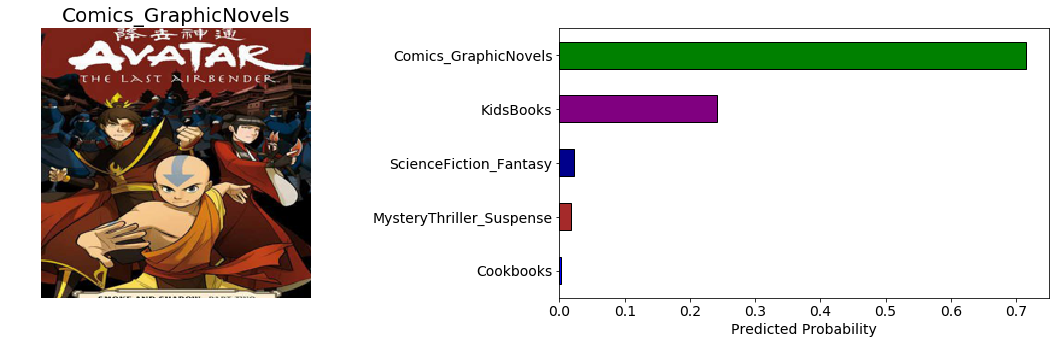

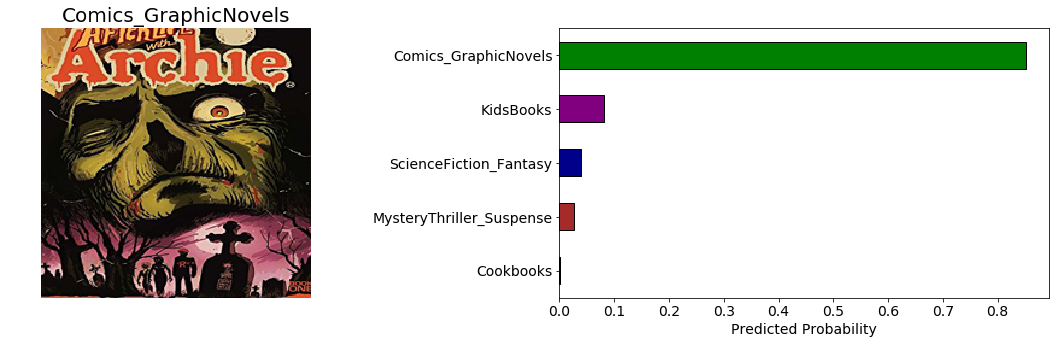

In [61]:
display_category(model_resnet, 'Comics_GraphicNovels')

                    class  top1   top5      loss  n_train  n_valid
4  ScienceFiction_Fantasy  44.0  100.0  1.279263     1632      350 /n


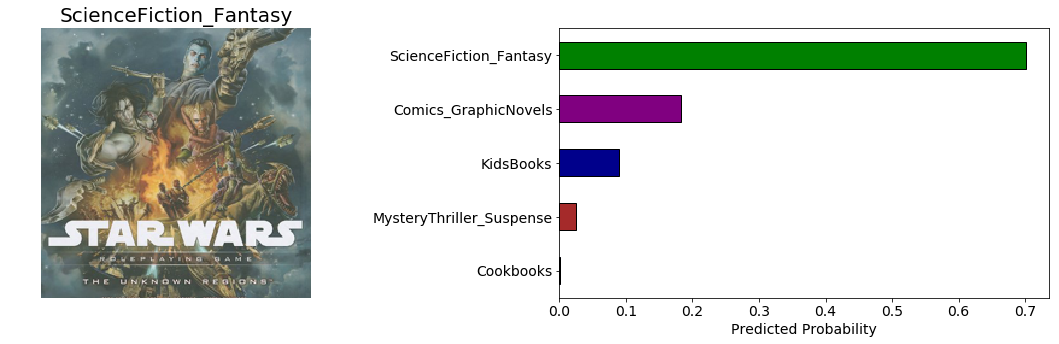

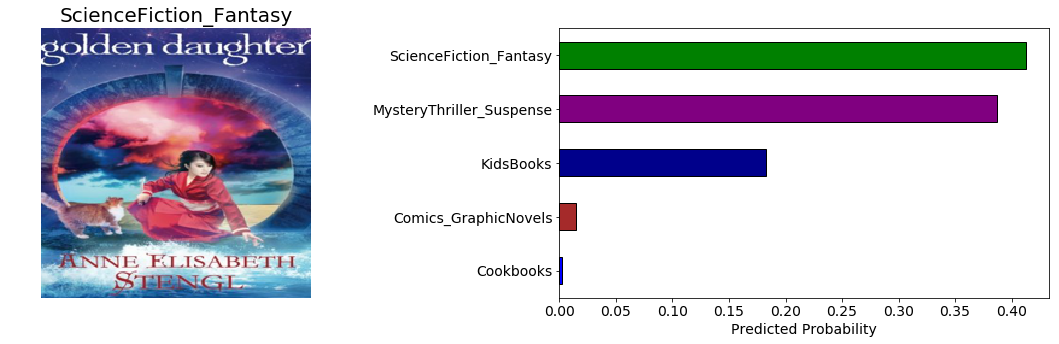

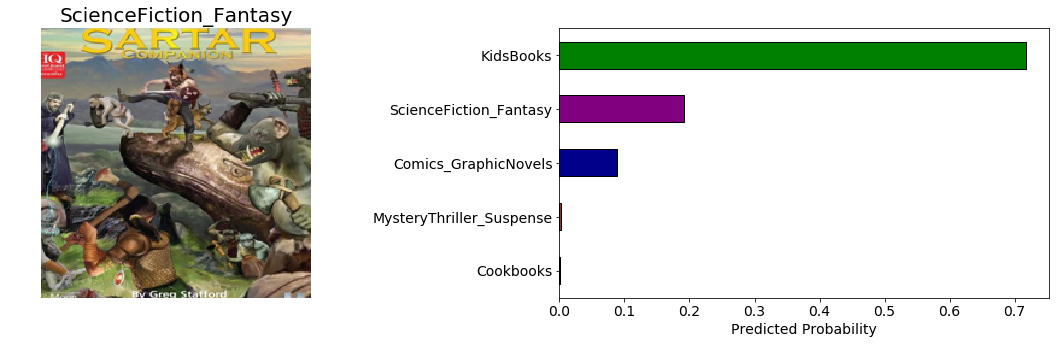

In [68]:
display_category(model_resnet, 'ScienceFiction_Fantasy')

       class       top1   top5     loss  n_train  n_valid
2  KidsBooks  66.666667  100.0  0.86293     2100      450 /n


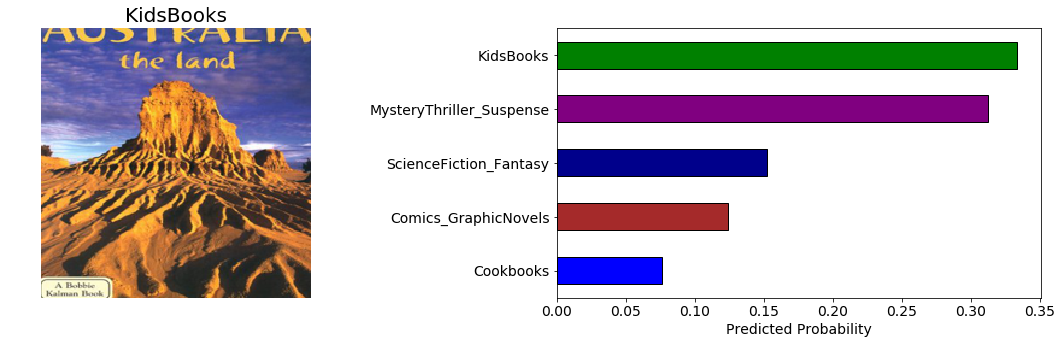

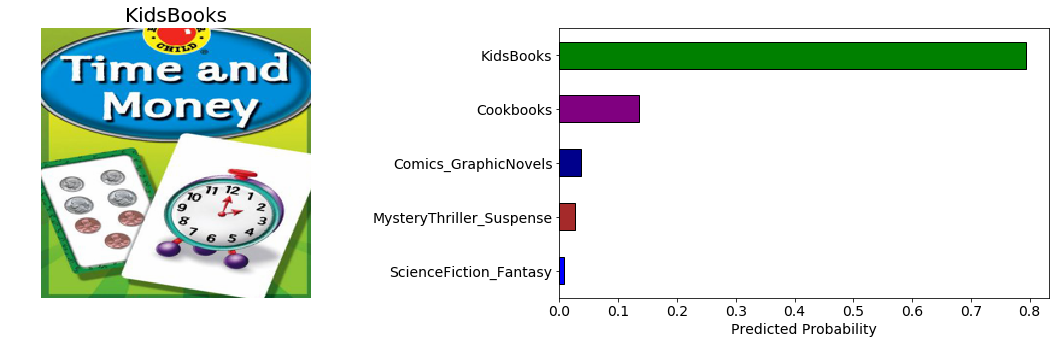

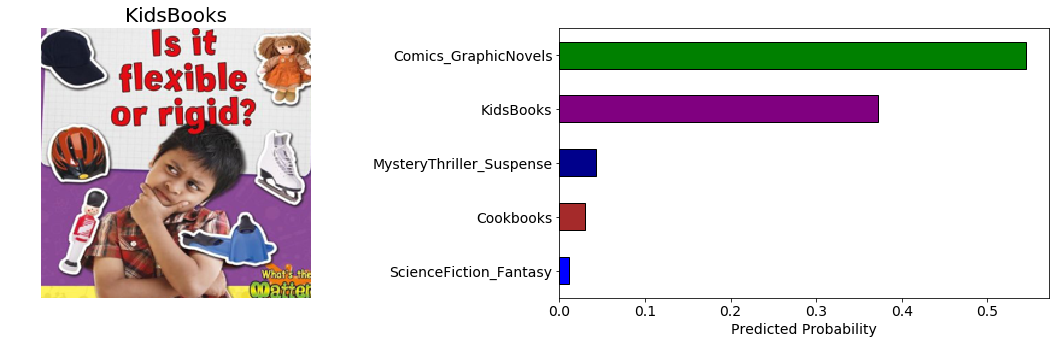

In [62]:
display_category(model_resnet, 'KidsBooks')

                      class       top1   top5      loss  n_train  n_valid
3  MysteryThriller_Suspense  73.489933  100.0  0.812384     1402      298 /n


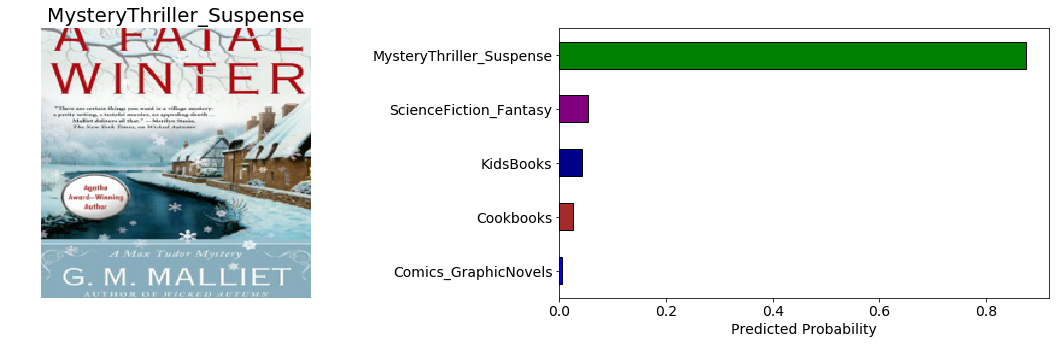

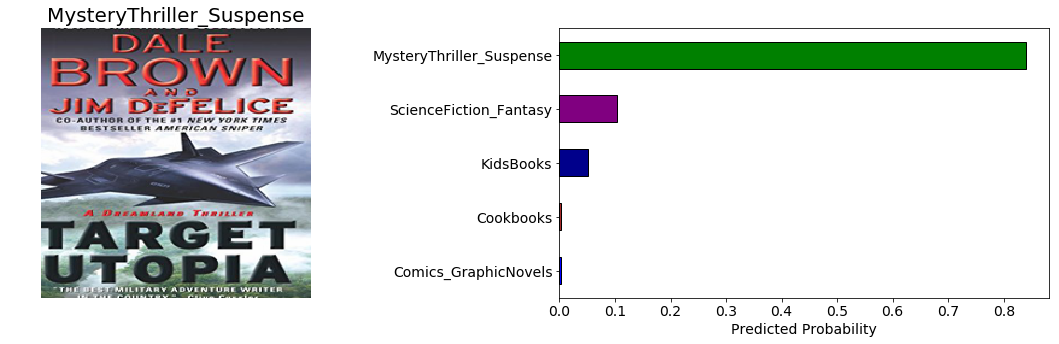

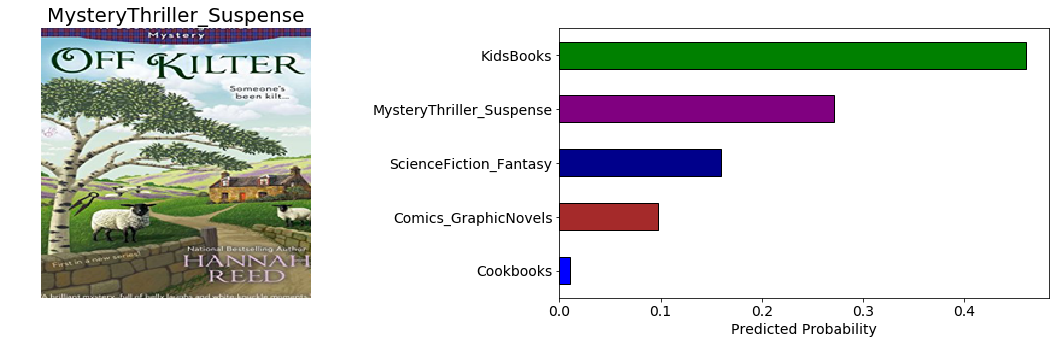

In [64]:
display_category(model_resnet, 'MysteryThriller_Suspense')

# Conclusions

We are able to make predictions of book covers with an accuracy of 64% using Resnet model. We also explored different Transfer Learning models to train the data and choose the best model to test our resultant data.

### References:
https://towardsdatascience.com/judging-a-book-by-its-cover-1365d001ef50

https://www.learnopencv.com/image-classification-using-transfer-learning-in-pytorch/ 

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

https://github.com/WillKoehrsen/pytorch_challenge
    
    